# Learning aggregate functions #



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import random
seed = 1387
random.seed(seed)
np.random.seed(seed)

## 1. Loading the data ##

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [3]:
#new_transactions = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])
#all_transactions = pd.concat([historical_transactions,new_transactions])
all_transactions = historical_transactions.sample(frac=0.1, random_state=seed)
all_transactions.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
22775109,N,C_ID_473b843c9d,333,N,0,A,437,M_ID_c0deafd324,-3,-0.713729,2017-08-21 15:38:00,1.0,9,15
10227162,Y,C_ID_71cb477648,304,N,0,A,80,M_ID_e6bc585098,-1,-0.736765,2018-01-19 21:52:31,5.0,20,37


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


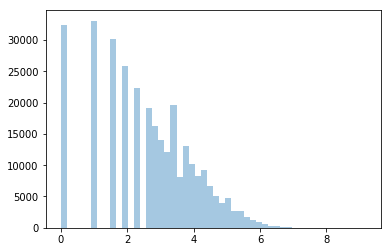

In [4]:
sns.distplot(np.log2(all_transactions.groupby('card_id').agg({'card_id': 'count'}).values), kde=False);

In [5]:
all_transactions.authorized_flag = all_transactions.authorized_flag == 'Y'
all_transactions.category_1 = all_transactions.category_1 == 'Y'
dummied = all_transactions
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['category_2'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['category_3'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['city_id'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['state_id'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['subsector_id'])
dummied = dummied.drop(columns=['installments', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_date'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2911236 entries, 22775109 to 10863614
Columns: 386 entries, authorized_flag to subsector_id_nan
dtypes: bool(2), float64(1), object(1), uint8(382)
memory usage: 1.1+ GB


In [6]:
from sklearn.preprocessing import StandardScaler
dummied.purchase_amount = StandardScaler().fit_transform(dummied.purchase_amount.values.reshape(-1, 1))

In [61]:
import tensorflow as tf

def train_sgd(df):
    'Train the neural network'
    num_units1 = 1
    learning_rate = 1E-3
    num_epochs = 40
    sample_fraction = 1E-4
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,dummied.shape[1]-1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    layer1 = tf.contrib.layers.fully_connected(inputs=X, num_outputs=num_units1, activation_fn=tf.nn.tanh, scope='layer1')
    reduced = tf.reduce_sum(layer1, axis=0, keepdims=True) #This will create a one-dimensional tensor of activations
    predicted = tf.contrib.layers.fully_connected(inputs=reduced, num_outputs=1, activation_fn=None, scope='layer2')
    cost = tf.reshape((Y-predicted)**2,[])
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            cards = df.sample(frac=sample_fraction)
            
            
            def run_one(row):
                'Run the optimization step for one row'
                x_value = dummied[dummied.card_id == str(row.name)].drop(columns=['card_id']).values
                y_value = np.array(row).reshape([1,1])
                _ , temp_cost = sess.run([train, cost], feed_dict={X: x_value, Y: y_value})
                return temp_cost

            
            minibatch_cost = float(cards.apply(run_one, axis=1).mean())
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))


In [67]:
import tensorflow as tf

def train_minibatch(seq, learning_rate=1E-3, num_epochs = 2000):
    'Train the neural network'
    num_units1 = 1
    sample_fraction = 1E-3
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,dummied.shape[1]-1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    cid = tf.placeholder('int64', shape=(None), name='card_ids')
    layer1 = tf.contrib.layers.fully_connected(inputs=X, num_outputs=num_units1, 
                                               activation_fn=None, scope='layer1') #tf.nn.relu
    reduced = tf.segment_sum(data=layer1, segment_ids=cid, name='segment_sum')
    predicted = tf.contrib.layers.fully_connected(inputs=reduced, num_outputs=1, activation_fn=None, scope='layer2')
    cost = tf.losses.mean_squared_error(labels=Y, predictions=predicted)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(cost)
    
    init = tf.global_variables_initializer()
    
    losses = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            cards = seq.sample(frac=sample_fraction)
            cards = cards.rename({cards.columns[0]:'target'})
            cards_df = pd.DataFrame(index=cards.index, data={'target': cards.values.reshape([-1])})
            cards_df['sequence_number'] = range(cards.shape[0])
            joined_df = dummied.join(cards_df, on='card_id', how='inner').sort_values(by='sequence_number')
            x_value = joined_df.drop(columns=['card_id', 'target', 'sequence_number']).values
            y_value = cards_df.target.values.reshape([-1,1])
            card_ids = joined_df.sequence_number
            _ , minibatch_cost = sess.run([train, cost], feed_dict={X: x_value, Y: y_value, cid: card_ids})
            losses.append(minibatch_cost)

            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
    return losses

Cost after epoch 0: 275.423279
Cost after epoch 100: 0.279981
Cost after epoch 200: 0.067120
Cost after epoch 300: 0.037103
Cost after epoch 400: 0.031991
Cost after epoch 500: 0.028656
Cost after epoch 600: 0.014721
Cost after epoch 700: 0.013750
Cost after epoch 800: 0.016654
Cost after epoch 900: 0.012508
Cost after epoch 1000: 0.110268
Cost after epoch 1100: 0.017480
Cost after epoch 1200: 0.014561
Cost after epoch 1300: 0.007719
Cost after epoch 1400: 0.034295
Cost after epoch 1500: 0.006165
Cost after epoch 1600: 0.009118
Cost after epoch 1700: 0.008836
Cost after epoch 1800: 0.004352
Cost after epoch 1900: 0.005265
Cost after epoch 2000: 0.014564


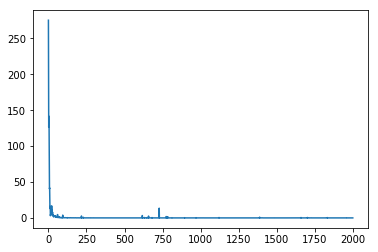

In [72]:
#Check if we can learn to count
count_cards = pd.DataFrame(dummied.groupby('card_id').count().purchase_amount)
losses = train_minibatch(count_cards, learning_rate=1E-2, num_epochs=2001)
plt.plot(losses);

Cost after epoch 0: 6.069956
Cost after epoch 100: 0.062653
Cost after epoch 200: 0.131697
Cost after epoch 300: 0.345231
Cost after epoch 400: 0.097499
Cost after epoch 500: 0.149844
Cost after epoch 600: 0.265756
Cost after epoch 700: 0.027562
Cost after epoch 800: 0.298730
Cost after epoch 900: 0.098620
Cost after epoch 1000: 0.192733
Cost after epoch 1100: 0.100099
Cost after epoch 1200: 0.038086
Cost after epoch 1300: 0.126696
Cost after epoch 1400: 0.464821
Cost after epoch 1500: 0.064915
Cost after epoch 1600: 0.030883
Cost after epoch 1700: 0.071793
Cost after epoch 1800: 0.077243
Cost after epoch 1900: 0.013142
Cost after epoch 2000: 0.028904


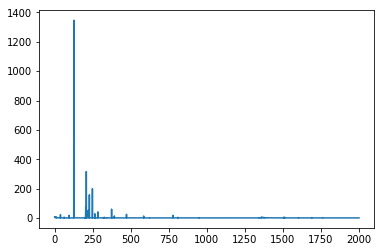

In [73]:
#Check if we can learn sum
amount_sum_cards = pd.DataFrame(dummied.groupby('card_id').agg({'purchase_amount': 'sum'}))
losses = train_minibatch(amount_sum_cards, learning_rate=1E-2, num_epochs=2001)
plt.plot(losses);

In [11]:
def verify_count(card_id):
    'Proove that the neural network can learn count'
    num_units1 = 1
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,dummied.shape[1]-1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    cid = tf.placeholder('int64', shape=(None), name='card_ids')
    layer1 = tf.contrib.layers.fully_connected(inputs=X, num_outputs=num_units1, 
                                               activation_fn=tf.nn.relu, scope='layer1', 
                                               weights_initializer=tf.zeros_initializer(),
                                              biases_initializer=tf.constant_initializer(1.0))
    reduced = tf.segment_sum(data=layer1, segment_ids=cid, name='segment_sum')
    predicted = tf.contrib.layers.fully_connected(inputs=reduced, num_outputs=1, activation_fn=None, scope='layer2',
                                                 weights_initializer=tf.constant_initializer(1.0), 
                                                 biases_initializer=tf.zeros_initializer())
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        card_data = dummied[dummied.card_id == card_id]
        trans_count = card_data.count().values[0]
        print('Expected: ', trans_count)
        x_value = card_data.drop(columns=['card_id']).values
        predicted_value = sess.run([predicted], feed_dict={X: x_value, cid: [0]*trans_count})
        print('Predicted: ',predicted_value)


In [12]:
verify_count('C_ID_0001793786')

Expected:  19
Predicted:  [array([[19.]], dtype=float32)]


In [13]:
def verify_sum(card_id):
    'Proove that the neural network can learn sum'
    num_units1 = 1
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,dummied.shape[1]-1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    cid = tf.placeholder('int64', shape=(None), name='card_ids')
    initial_weights = np.zeros(shape=[dummied.shape[1]-1])
    initial_weights[list(dummied.drop(columns=['card_id']).columns).index('purchase_amount')] = 1
    layer1 = tf.contrib.layers.fully_connected(inputs=X, num_outputs=num_units1, 
                                               activation_fn=None, scope='layer1', 
                                               weights_initializer=tf.constant_initializer(initial_weights),
                                              biases_initializer=tf.zeros_initializer())
    reduced = tf.segment_sum(data=layer1, segment_ids=cid, name='segment_sum')
    predicted = tf.contrib.layers.fully_connected(inputs=reduced, num_outputs=1, activation_fn=None, scope='layer2',
                                                 weights_initializer=tf.constant_initializer(1.0), 
                                                 biases_initializer=tf.zeros_initializer())
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        card_data = dummied[dummied.card_id == card_id]
        trans_count = card_data.count().values[0]
        print('Expected: ', card_data.purchase_amount.sum())
        x_value = card_data.drop(columns=['card_id']).values
        predicted_value = sess.run([predicted], feed_dict={X: x_value, cid: [0]*trans_count})
        print('Predicted: ',predicted_value)


In [14]:
verify_sum('C_ID_0001793786')

Expected:  -0.015156484592460006
Predicted:  [array([[-0.01515648]], dtype=float32)]


In [15]:
dummied.head()

,authorized_flag,card_id,category_1,purchase_amount,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_2_nan,category_3_B,...,subsector_id_33.0,subsector_id_34.0,subsector_id_35.0,subsector_id_36.0,subsector_id_37.0,subsector_id_38.0,subsector_id_39.0,subsector_id_40.0,subsector_id_41.0,subsector_id_nan
22775109,False,C_ID_473b843c9d,False,-0.003658,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10227162,True,C_ID_71cb477648,False,-0.003780,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
933740,True,C_ID_ad9acd4831,False,-0.003794,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18645748,True,C_ID_34201164aa,False,-0.003516,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8503380,True,C_ID_faed58af75,True,-0.003523,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
